In [3]:
import numpy as np
import onnx
import onnxruntime as ort
from transformers import AutoTokenizer

# Load the tokenizer and ONNX model once at startup
model_name = 'distilgpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Path to the ONNX model
onnx_model_path = '../model/model.onnx'

# Create an inference session
ort_session = ort.InferenceSession(onnx_model_path)

def extract_layers(model_path):
    """
    Extracts all layers (nodes) from an ONNX model.

    Parameters:
        model_path (str): Path to the ONNX model file.

    Returns:
        List[Dict]: A list of dictionaries containing layer information.
    """
    # Load the ONNX model
    model = onnx.load(model_path)
    layers = []

    # Iterate through all nodes in the graph
    for idx, node in enumerate(model.graph.node):
        layer_info = {
            'layer_index': idx,
            'name': node.name if node.name else f"Unnamed_{idx}",
            'op_type': node.op_type,
            'input': node.input,
            'output': node.output,
            'attributes': {attr.name: onnx.helper.get_attribute_value(attr) for attr in node.attribute}
        }
        layers.append(layer_info)

    return layers

# Example usage
if __name__ == "__main__":
    layers = extract_layers(onnx_model_path)
    print(f"Total Layers: {len(layers)}\n")
    for layer in layers:
        print(f"Layer {layer['layer_index']}:")
        print(f"  Name      : {layer['name']}")
        print(f"  Op Type   : {layer['op_type']}")
        print(f"  Inputs    : {layer['input']}")
        print(f"  Outputs   : {layer['output']}")
        print(f"  Attributes : {layer['attributes']}\n")


/Users/mahdi/repos/LLMviz.io/llmviz/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

/Users/mahdi/repos/LLMviz.io/llmviz/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Total Layers: 2600

Layer 0:
  Name      : /transformer/Shape
  Op Type   : Shape
  Inputs    : ['input_ids']
  Outputs   : ['/transformer/Shape_output_0']
  Attributes : {}

Layer 1:
  Name      : /transformer/Constant
  Op Type   : Constant
  Inputs    : []
  Outputs   : ['/transformer/Constant_output_0']
  Attributes : {'value': data_type: 7
raw_data: "\001\000\000\000\000\000\000\000"
}

Layer 2:
  Name      : /transformer/Gather
  Op Type   : Gather
  Inputs    : ['/transformer/Shape_output_0', '/transformer/Constant_output_0']
  Outputs   : ['/transformer/Gather_output_0']
  Attributes : {'axis': 0}

Layer 3:
  Name      : /transformer/Constant_1
  Op Type   : Constant
  Inputs    : []
  Outputs   : ['/transformer/Constant_1_output_0']
  Attributes : {'value': dims: 1
data_type: 7
raw_data: "\377\377\377\377\377\377\377\377"
}

Layer 4:
  Name      : Constant_955
  Op Type   : Constant
  Inputs    : []
  Outputs   : ['onnx::Unsqueeze_155']
  Attributes : {'value': dims: 1
data_ty

In [5]:
import numpy as np
import plotly.graph_objects as go

# Example layers with activation data
layers = [
    {
        'layer_index': 0,
        'name': 'Input',
        'op_type': 'Input',
        'inputs': [],
        'outputs': ['input_tensor'],
        'attributes': {},
        'activations': np.random.rand(5, 5)
    },
    {
        'layer_index': 1,
        'name': 'MatMul_1',
        'op_type': 'MatMul',
        'inputs': ['input_tensor', 'weight1'],
        'outputs': ['matmul_output'],
        'attributes': {},
        'activations': np.random.rand(5, 5)
    },
    {
        'layer_index': 2,
        'name': 'Add_1',
        'op_type': 'Add',
        'inputs': ['matmul_output', 'bias1'],
        'outputs': ['add_output'],
        'attributes': {},
        'activations': np.random.rand(5, 5)
    },
    {
        'layer_index': 3,
        'name': 'Relu_1',
        'op_type': 'Relu',
        'inputs': ['add_output'],
        'outputs': ['relu_output'],
        'attributes': {},
        'activations': np.random.rand(5, 5)
    },
    # Add more layers as needed
]




# Initialize figure
fig = go.Figure()

# Function to add operation blocks
def add_operation_block(fig, layer_x, operation_y, op_type, z=0):
    size = 0.4
    fig.add_trace(go.Mesh3d(
        x=[layer_x - size, layer_x + size, layer_x + size, layer_x - size,
           layer_x - size, layer_x + size, layer_x + size, layer_x - size],
        y=[operation_y - size, operation_y - size, operation_y + size, operation_y + size,
           operation_y - size, operation_y - size, operation_y + size, operation_y + size],
        z=[z, z, z, z, z + size, z + size, z + size, z + size],
        color='lightblue',
        opacity=0.6,
        name=op_type,
        hoverinfo='text',
        text=op_type
    ))
    # Add text label
    fig.add_trace(go.Scatter3d(
        x=[layer_x],
        y=[operation_y],
        z=[z + size + 0.1],
        mode='text',
        text=[op_type],
        showlegend=False
    ))

# Function to add activation bars
def add_activation_bars(fig, layer_x, activations, layer_index):
    num_rows, num_cols = activations.shape
    bar_spacing = 0.3
    for i in range(num_rows):
        for j in range(num_cols):
            x = layer_x
            y = i * bar_spacing
            z = j * bar_spacing
            fig.add_trace(go.Scatter3d(
                x=[x, x],
                y=[y, y],
                z=[z, z + activations[i, j]],
                mode='lines',
                line=dict(color='orange', width=4),
                showlegend=False
            ))

# Add layers and their components
for layer in layers:
    layer_x = layer['layer_index']
    op_type = layer['op_type']
    
    # Visualize operation
    add_operation_block(fig, layer_x, 0, op_type, z=0)
    
    # Visualize activations
    add_activation_bars(fig, layer_x, layer['activations'], layer['layer_index'])

# Define layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Layers', tickvals=list(range(len(layers))), ticktext=[layer['name'] for layer in layers]),
        yaxis=dict(title='Operations', range=[-1, 2]),
        zaxis=dict(title='Activation Values', range=[0, 1]),
        aspectratio=dict(x=1, y=1, z=0.5),
    ),
    title="3D Visualization of Model's Computational Flow",
    showlegend=False
)

# Show figure
fig.show()



In [3]:
import numpy as np
import onnx
import onnxruntime as ort
from transformers import AutoTokenizer

# Load the tokenizer and ONNX model once at startup
model_name = 'distilgpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Path to the ONNX model
onnx_model_path = '../model/model.onnx'

# Create an inference session
ort_session = ort.InferenceSession(onnx_model_path)

def extract_layers(model_path):
    """
    Extracts all layers (nodes) from an ONNX model.

    Parameters:
        model_path (str): Path to the ONNX model file.

    Returns:
        List[Dict]: A list of dictionaries containing layer information.
    """
    model = onnx.load(model_path)
    layers = []

    for idx, node in enumerate(model.graph.node):
        layer_info = {
            'layer_index': idx,
            'name': node.name if node.name else f"Unnamed_{idx}",
            'op_type': node.op_type,
            'input': node.input,
            'output': node.output,
            'attributes': {attr.name: onnx.helper.get_attribute_value(attr) for attr in node.attribute}
        }
        layers.append(layer_info)

    return layers

def get_layer_shape(output_name, ort_outputs):
    """Get the shape of a layer's output."""
    for key, value in ort_outputs.items():
        if key == output_name:
            return value.shape
    return None

def run_inference(input_text):
    """Run inference on the input text and return the outputs."""
    input_ids = tokenizer.encode(input_text, return_tensors='np')
    ort_inputs = {
        'input_ids': input_ids,
        'attention_mask': np.ones_like(input_ids)
    }
    ort_outputs = ort_session.run(None, ort_inputs)
    return dict(zip([o.name for o in ort_session.get_outputs()], ort_outputs))

def analyze_layers(input_text):
    """Analyze layers and their outputs for a given input."""
    layers = extract_layers(onnx_model_path)
    ort_outputs = run_inference(input_text)

    print(f"Input text: '{input_text}'")
    print(f"Total Layers: {len(layers)}\n")

    for layer in layers:
        print(f"Layer {layer['layer_index']}:")
        print(f"  Name      : {layer['name']}")
        print(f"  Op Type   : {layer['op_type']}")
        print(f"  Inputs    : {layer['input']}")
        print(f"  Outputs   : {layer['output']}")
        
        # Get shapes of input and output tensors
        input_shapes = [get_layer_shape(inp, ort_outputs) for inp in layer['input']]
        output_shapes = [get_layer_shape(out, ort_outputs) for out in layer['output']]
        
        print(f"  Input Shapes : {input_shapes}")
        print(f"  Output Shapes: {output_shapes}")
        
        print(f"  Attributes : {layer['attributes']}")
        
        # Print the operation that took place
        if layer['op_type'] in ['Add', 'Mul', 'MatMul', 'Div']:
            print(f"  Operation  : Element-wise {layer['op_type'].lower()} of inputs")
        elif layer['op_type'] == 'Reshape':
            print(f"  Operation  : Reshaping input tensor")
        elif layer['op_type'] == 'Transpose':
            print(f"  Operation  : Transposing input tensor")
        elif layer['op_type'] == 'Softmax':
            print(f"  Operation  : Applying softmax function")
        else:
            print(f"  Operation  : Applying {layer['op_type']} operation")
        
        # Print where the results are going next
        next_layer_indices = [i for i, l in enumerate(layers) if any(out in l['input'] for out in layer['output'])]
        if next_layer_indices:
            print(f"  Next Layers: {next_layer_indices}")
        else:
            print("  Next Layers: This is an output layer")
        
        print("\n")

if __name__ == "__main__":
    user_input = input("Enter a text to analyze: ")
    analyze_layers(user_input)

Input text: 'hello'
Total Layers: 1427

Layer 0:
  Name      : /transformer/Shape
  Op Type   : Shape
  Inputs    : ['input_ids']
  Outputs   : ['/transformer/Shape_output_0']
  Input Shapes : [None]
  Output Shapes: [None]
  Attributes : {}
  Operation  : Applying Shape operation
  Next Layers: [2]


Layer 1:
  Name      : /transformer/Constant
  Op Type   : Constant
  Inputs    : []
  Outputs   : ['/transformer/Constant_output_0']
  Input Shapes : []
  Output Shapes: [None]
  Attributes : {'value': data_type: 7
raw_data: "\001\000\000\000\000\000\000\000"
}
  Operation  : Applying Constant operation
  Next Layers: [2]


Layer 2:
  Name      : /transformer/Gather
  Op Type   : Gather
  Inputs    : ['/transformer/Shape_output_0', '/transformer/Constant_output_0']
  Outputs   : ['/transformer/Gather_output_0']
  Input Shapes : [None, None]
  Output Shapes: [None]
  Attributes : {'axis': 0}
  Operation  : Applying Gather operation
  Next Layers: [5, 12, 28, 30, 32, 69, 74, 98, 1421]


La

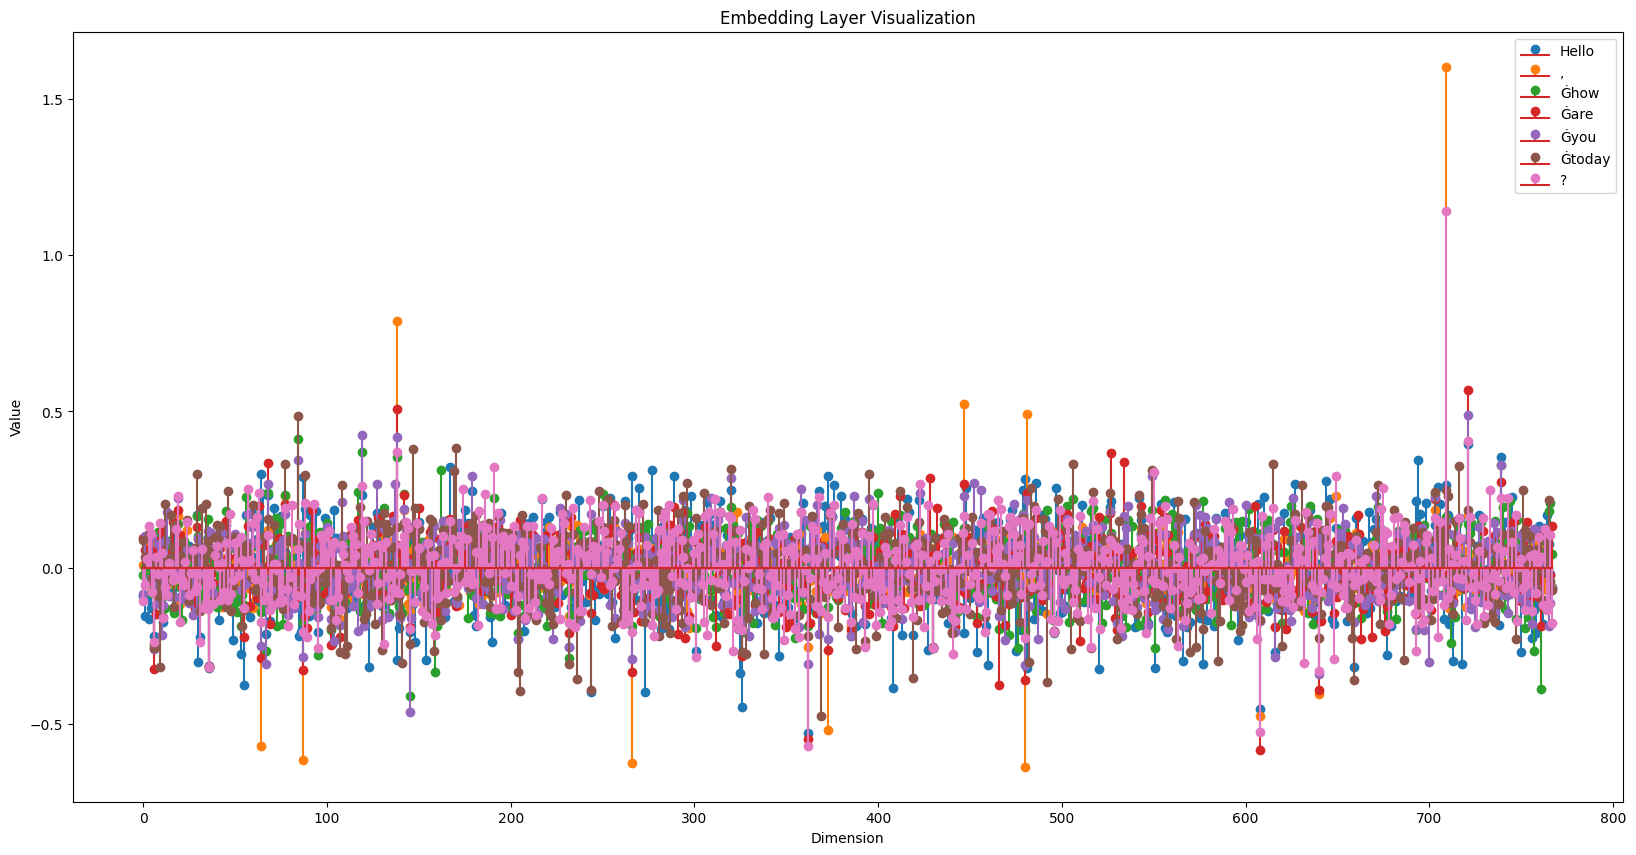

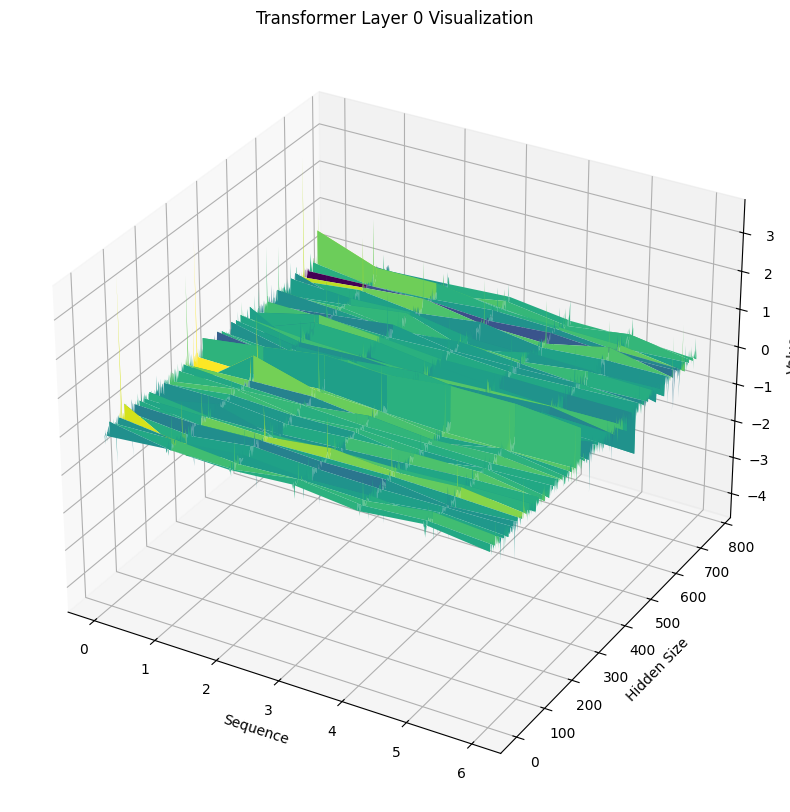

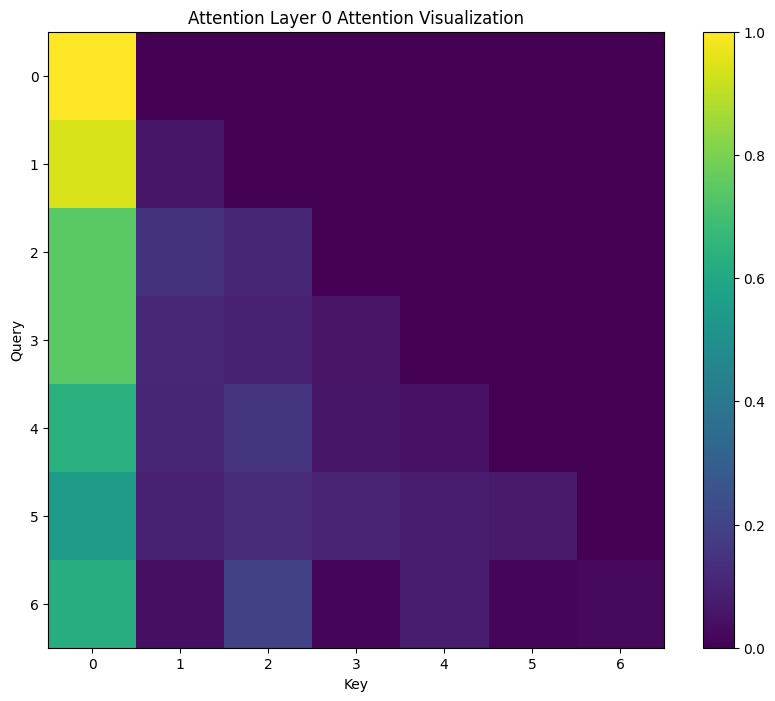

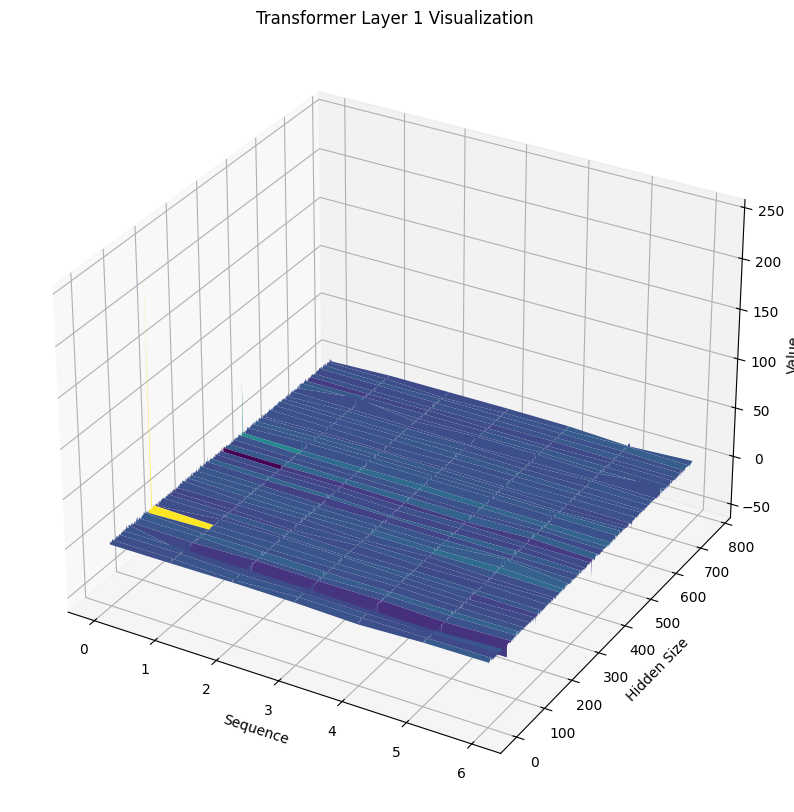

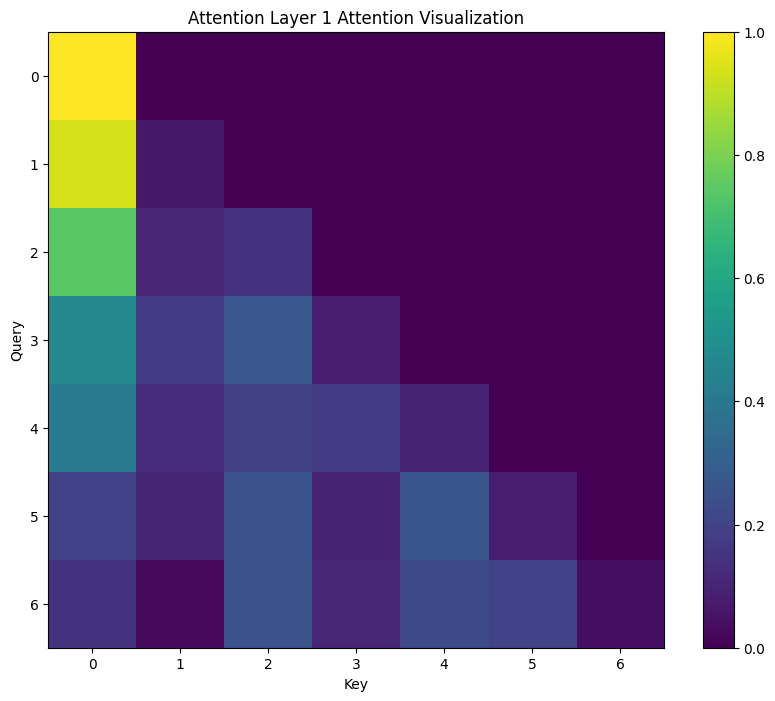

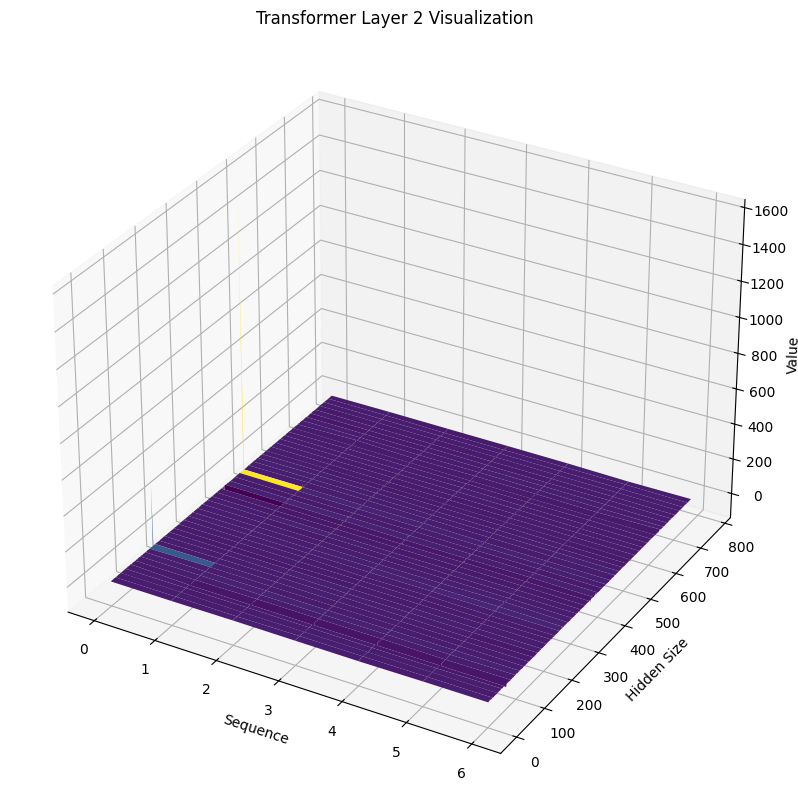

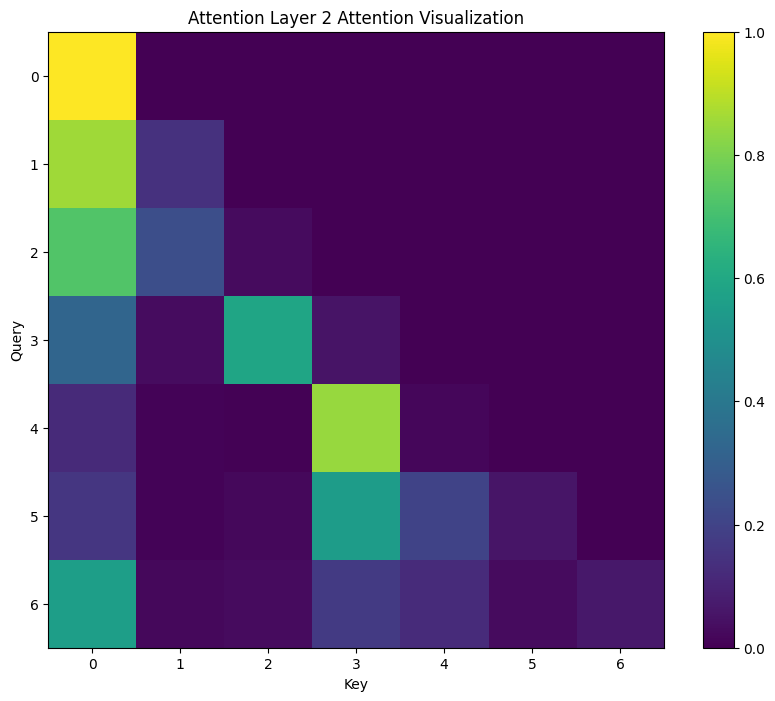

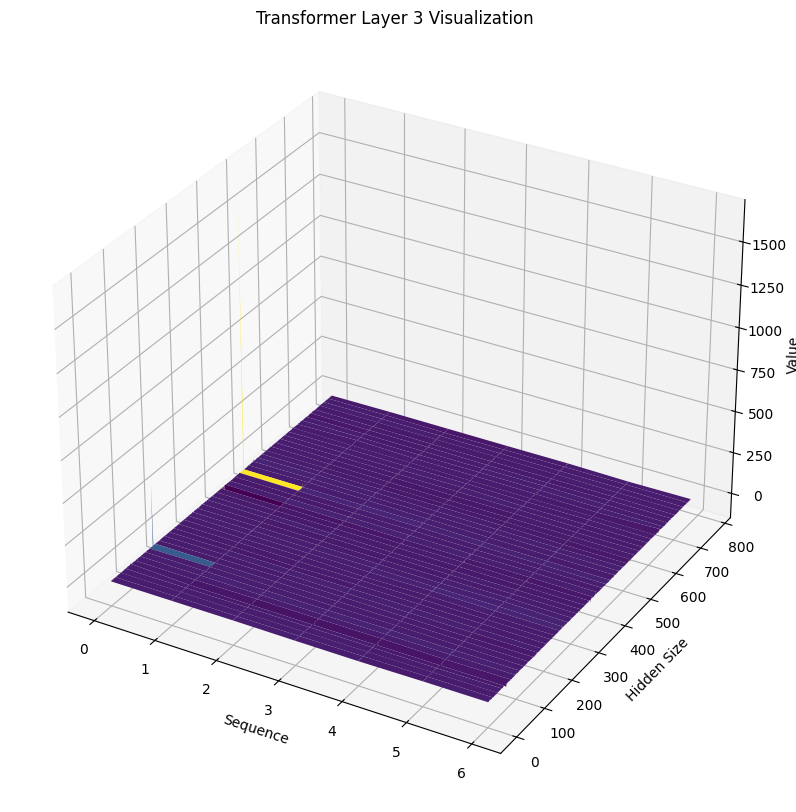

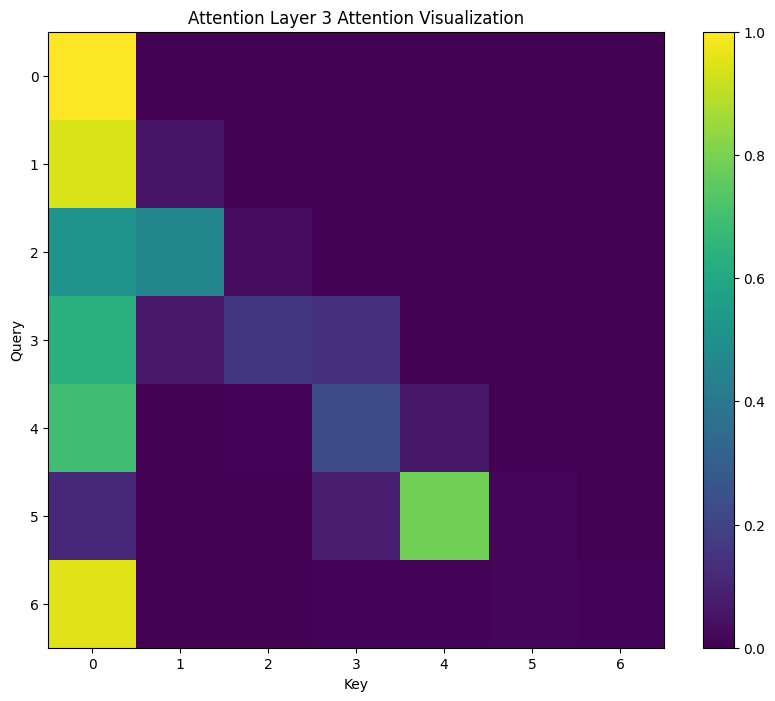

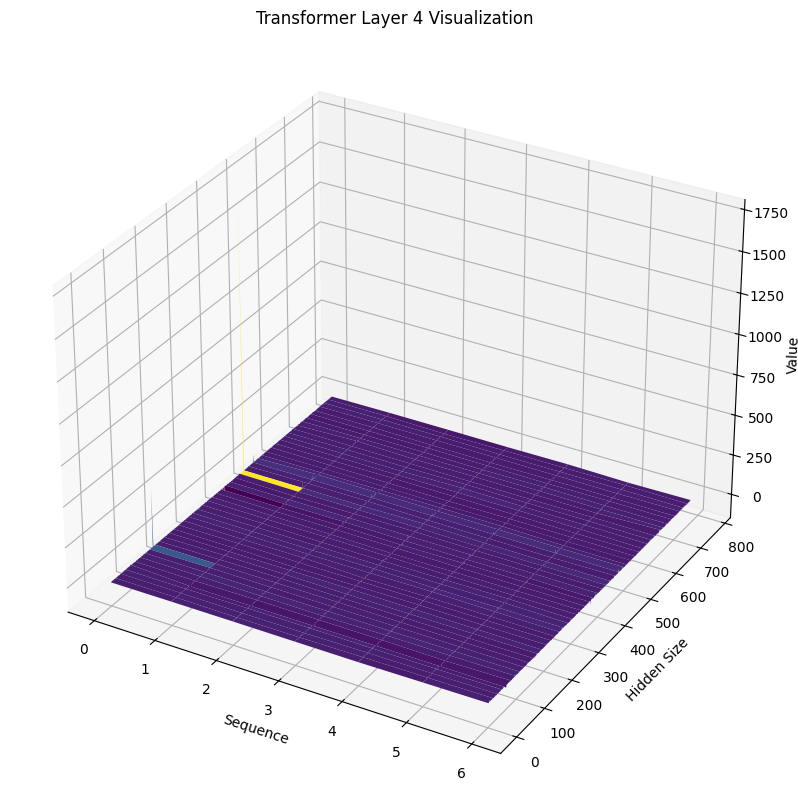

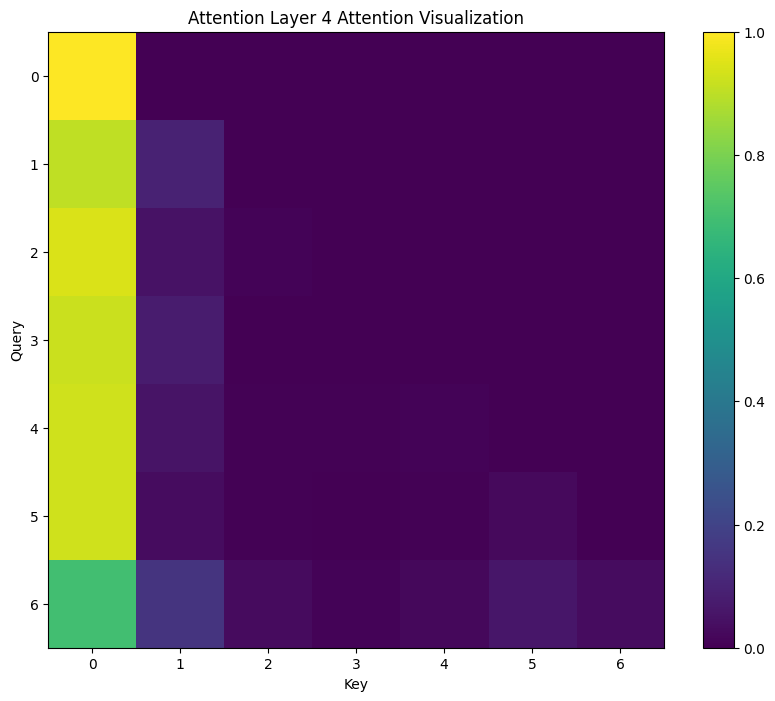

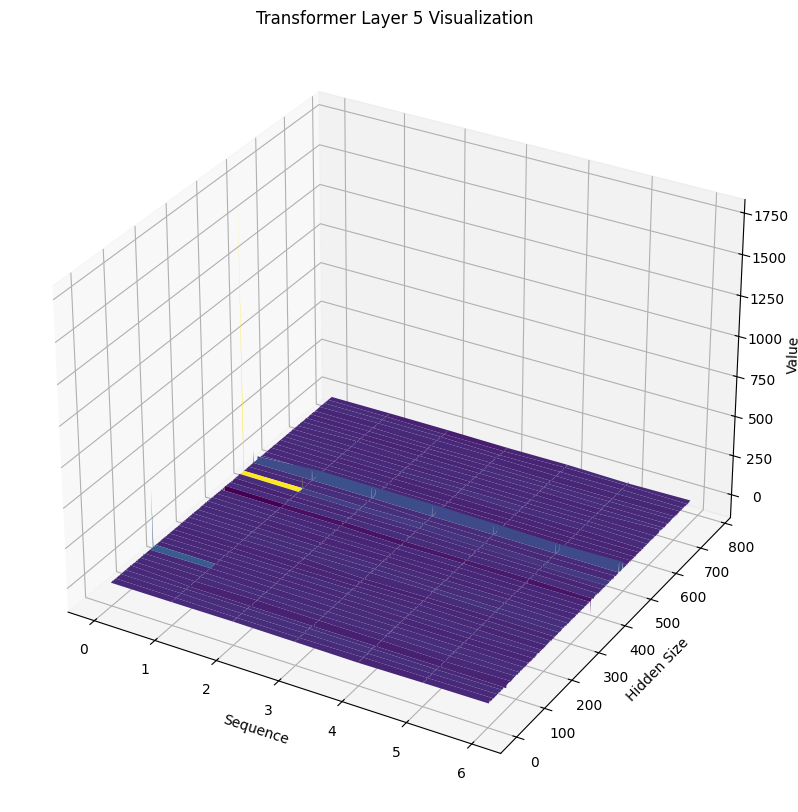

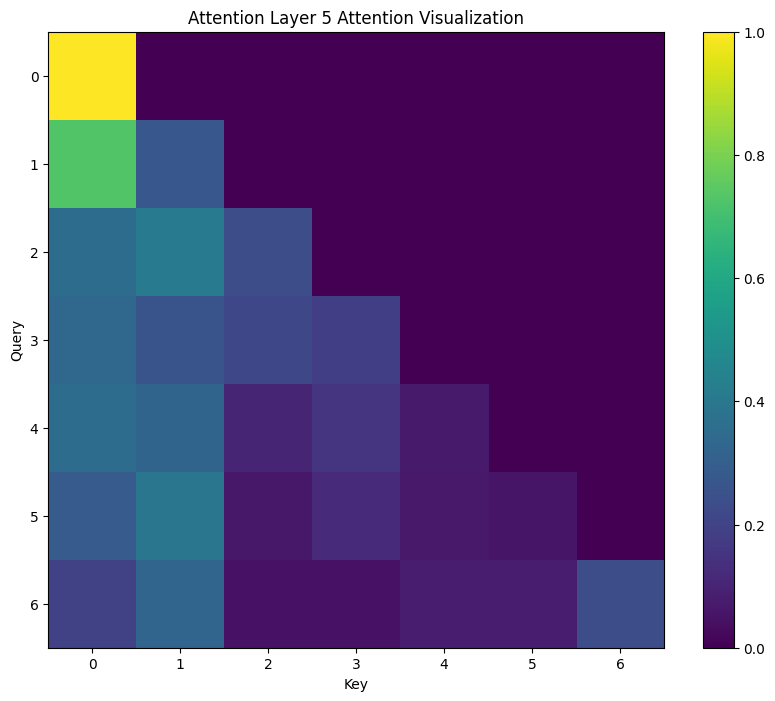

AttributeError: 'GPT2Model' object has no attribute 'transformer'

In [9]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModel.from_pretrained("distilgpt2")

# Move model to GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Function to visualize embeddings
def visualize_embeddings(embeddings, tokens):
    plt.figure(figsize=(20, 10))
    for i, token in enumerate(tokens):
        plt.stem(embeddings[i], linefmt=f'C{i}-', markerfmt=f'C{i}o', label=token)
    plt.legend()
    plt.title("Embedding Layer Visualization")
    plt.xlabel("Dimension")
    plt.ylabel("Value")
    plt.show()

# Updated function to visualize transformer layers in 3D
def visualize_transformer_3d(layer_output, layer_name):
    layer_output = layer_output[0].detach().cpu().numpy()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(layer_output.shape[0])
    y = np.arange(layer_output.shape[1])
    x, y = np.meshgrid(x, y)
    ax.plot_surface(x, y, layer_output.T, cmap='viridis')
    ax.set_title(f"{layer_name} Visualization")
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Hidden Size")
    ax.set_zlabel("Value")
    plt.show()

# Function to visualize attention
def visualize_attention(attention, layer_name):
    plt.figure(figsize=(10, 8))
    plt.imshow(attention[0, 0].detach().cpu().numpy(), cmap='viridis')
    plt.title(f"{layer_name} Attention Visualization")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.colorbar()
    plt.show()

# Function to run inference and visualize
def run_and_visualize(text):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

    # Visualize embeddings
    embeddings = model.get_input_embeddings()(inputs['input_ids'][0]).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    visualize_embeddings(embeddings, tokens)

    # Visualize transformer layers and attention
    for i, (hidden_state, attention) in enumerate(zip(outputs.hidden_states, outputs.attentions)):
        visualize_transformer_3d(hidden_state, f"Transformer Layer {i}")
        visualize_attention(attention, f"Attention Layer {i}")

    # Visualize feed-forward network (approximation)
    ffn_output = model.transformer.layer[-1].ffn(outputs.hidden_states[-1])
    visualize_transformer_3d(ffn_output, "Feed-Forward Network Output")

    # Output metrics
    print(f"Last hidden state shape: {outputs.last_hidden_state.shape}")
    print(f"Number of layers: {len(outputs.hidden_states)}")
    print(f"Attention heads: {outputs.attentions[0].shape[1]}")

# Run the visualization
text = "Hello, how are you today?"
run_and_visualize(text)

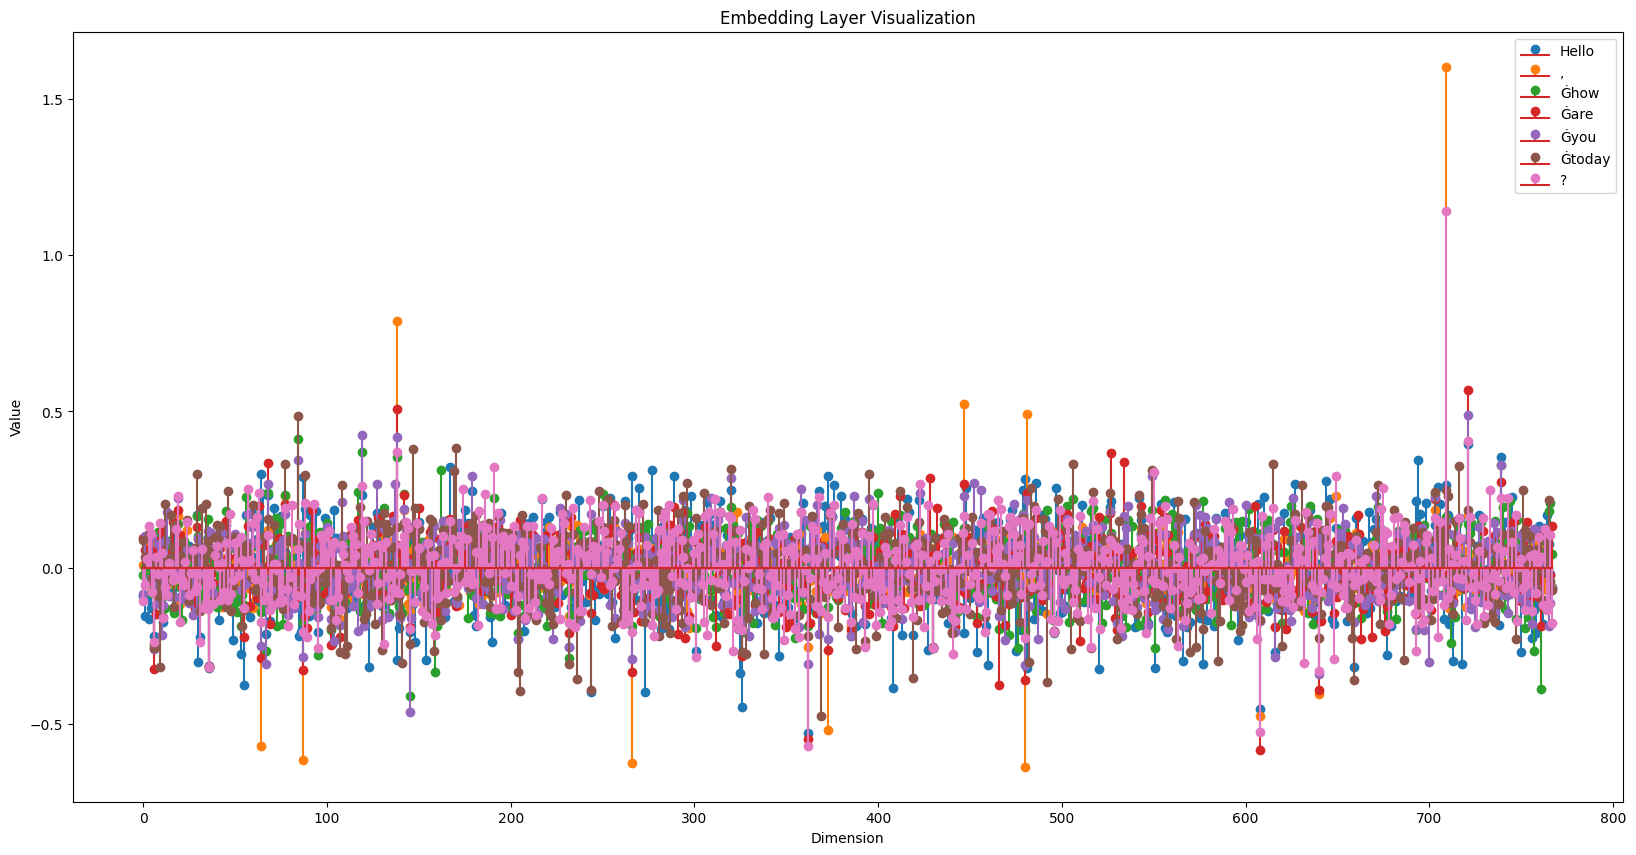

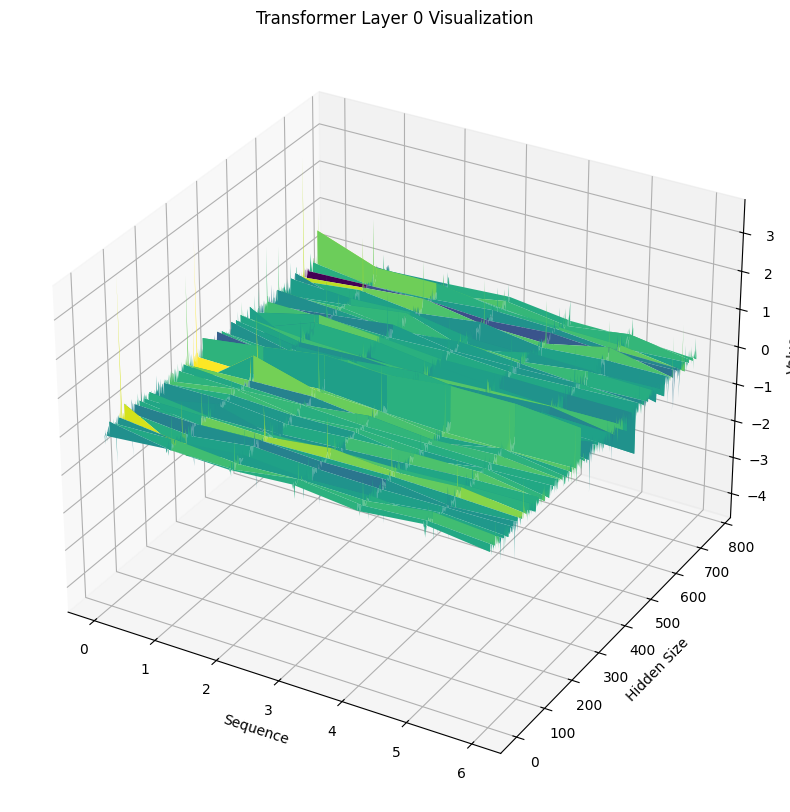

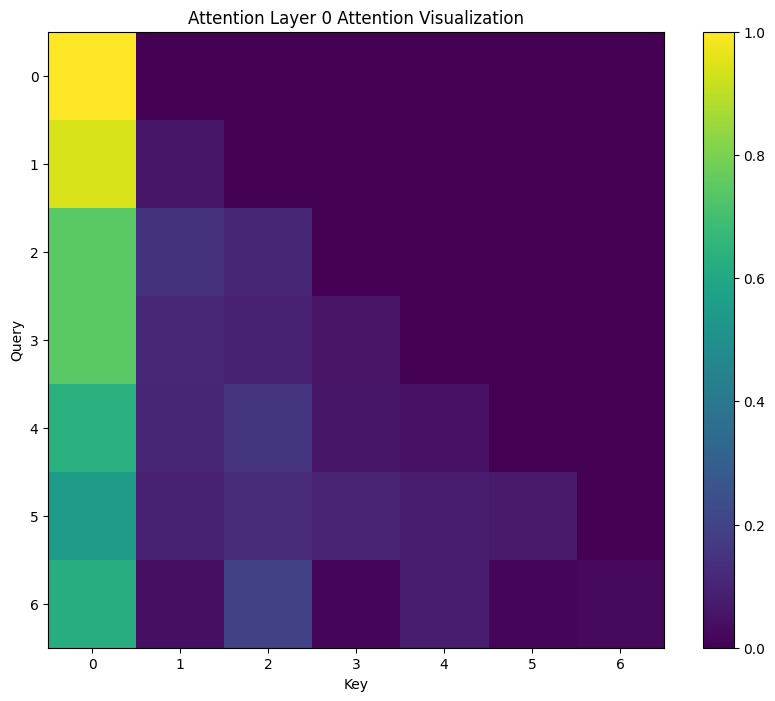

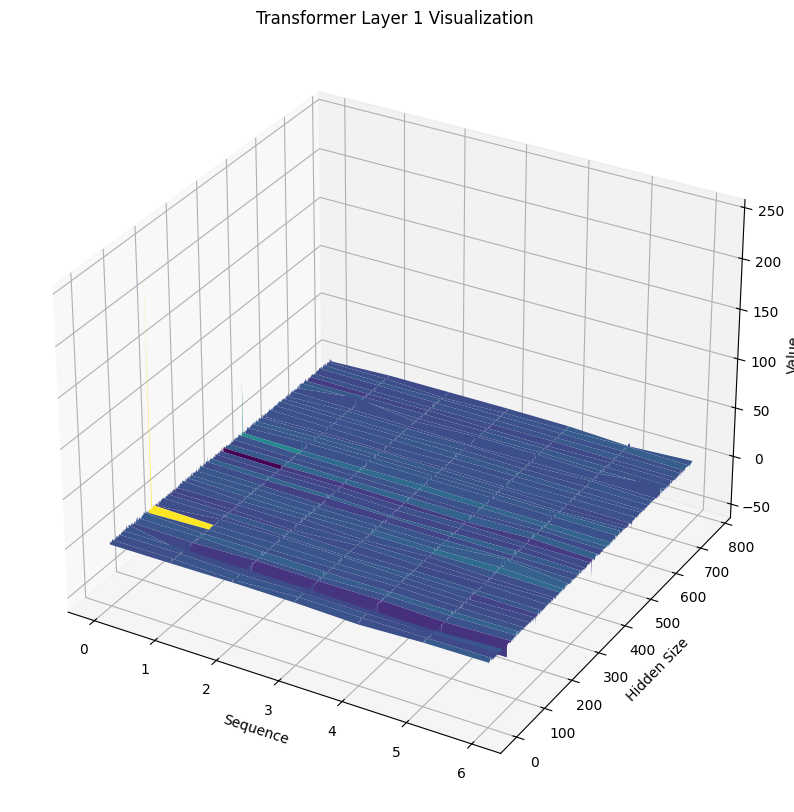

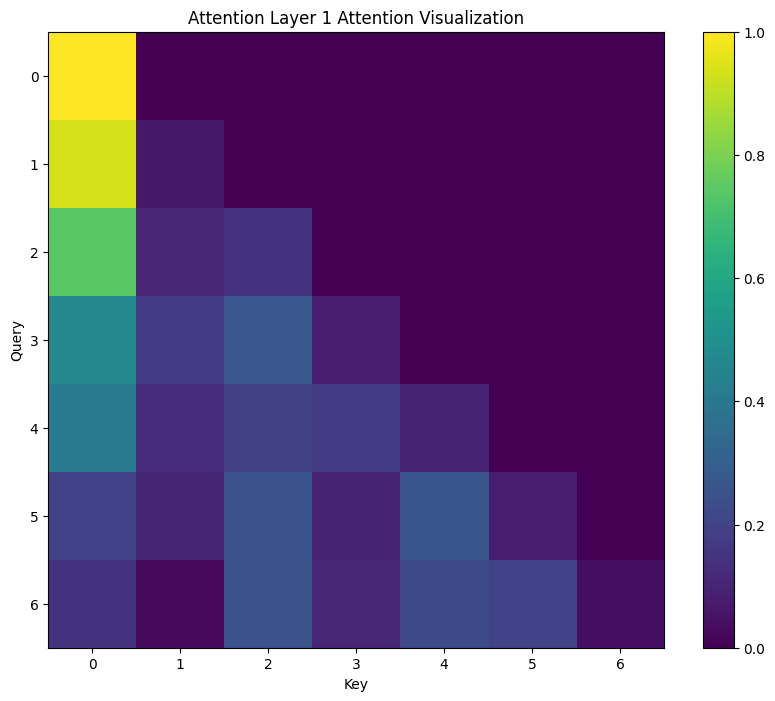

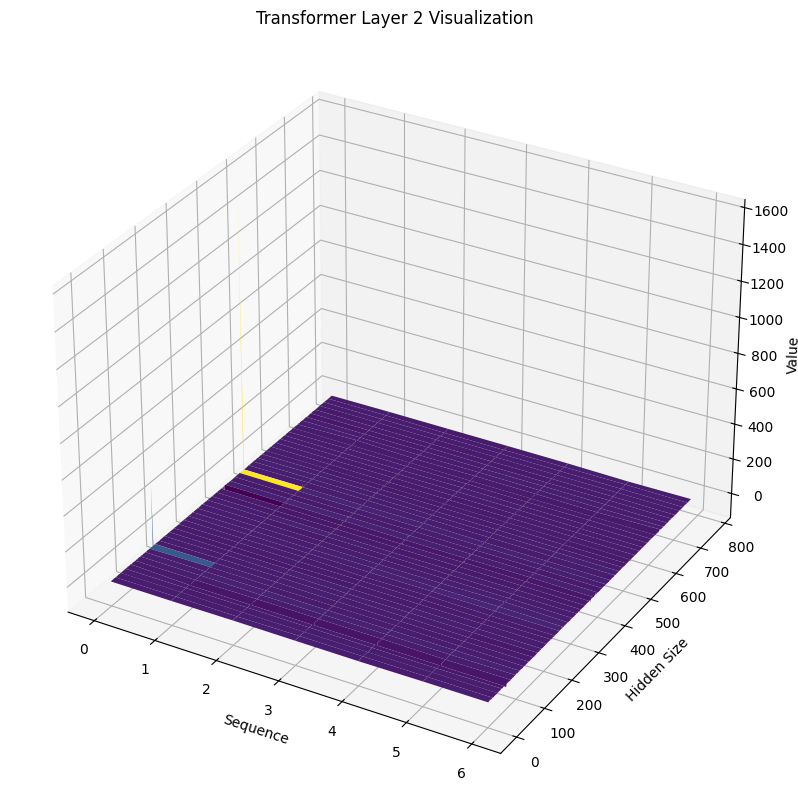

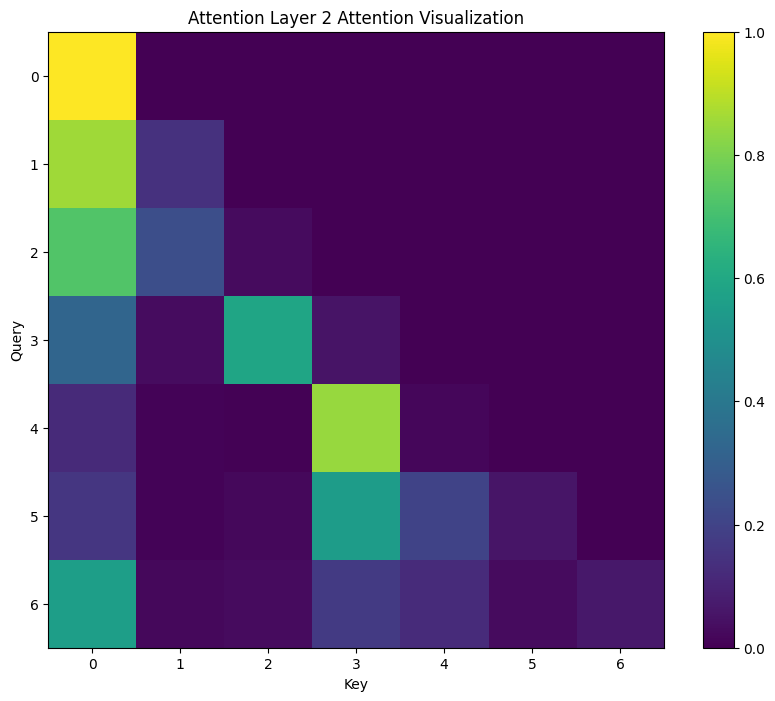

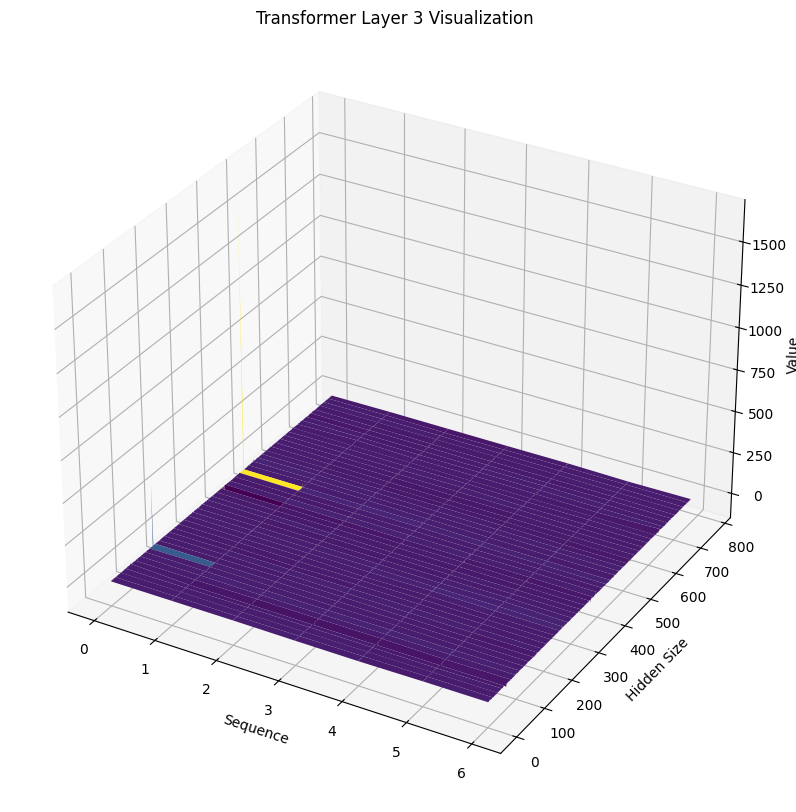

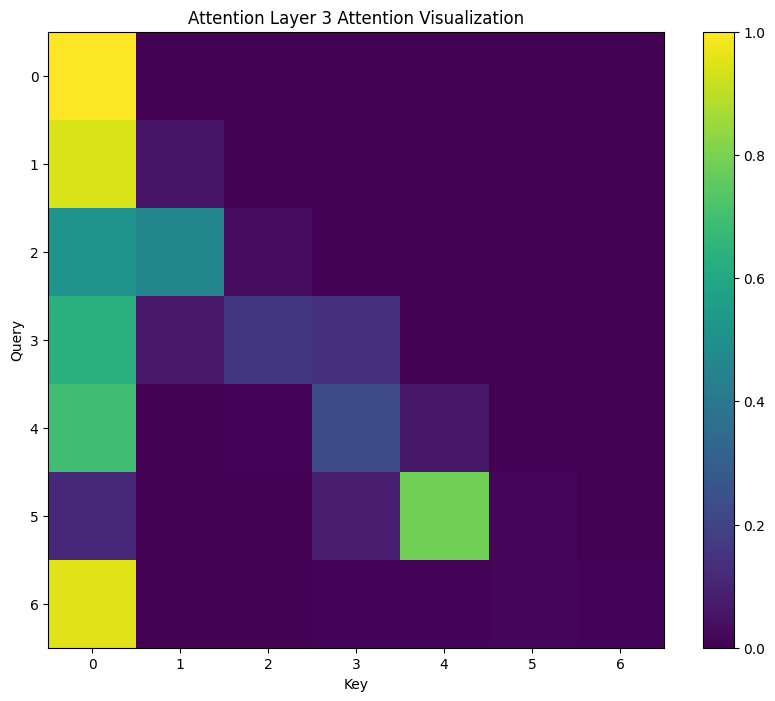

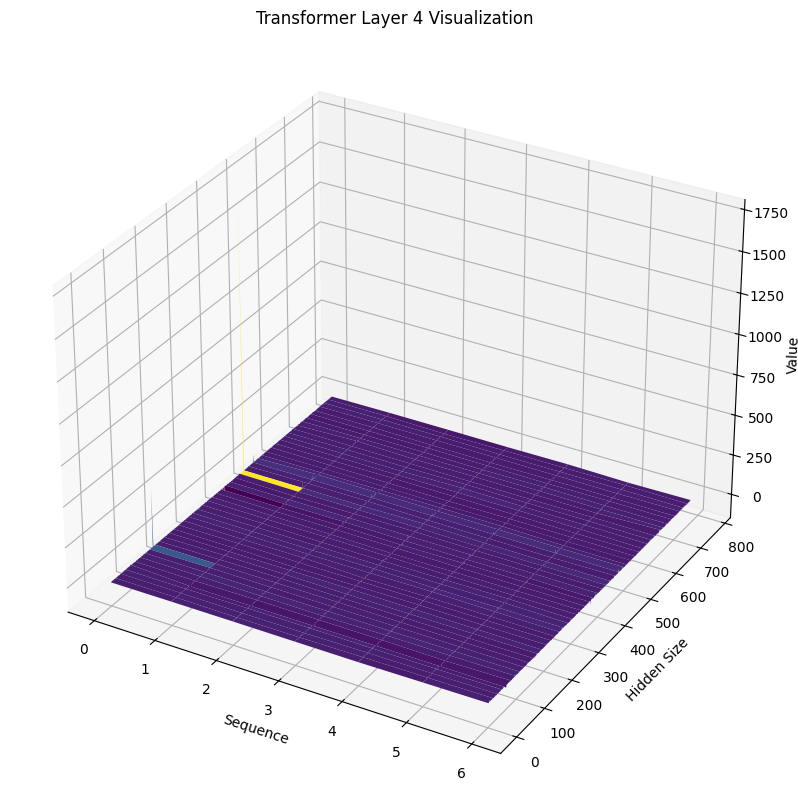

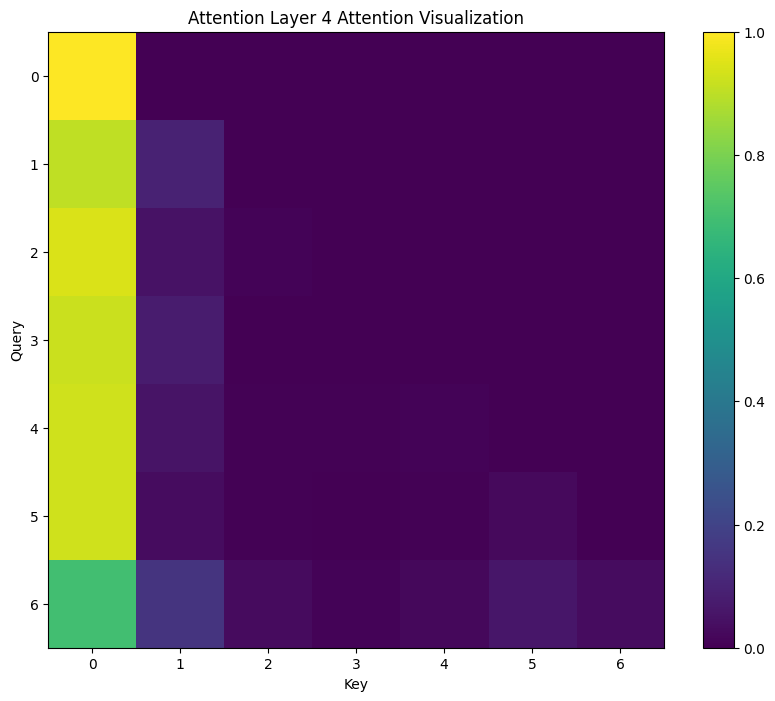

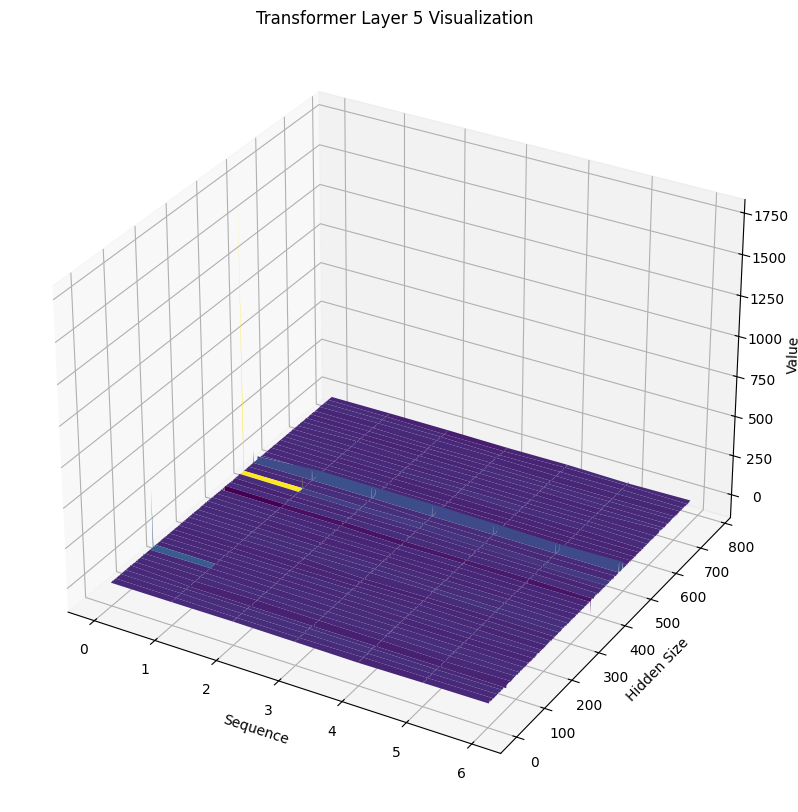

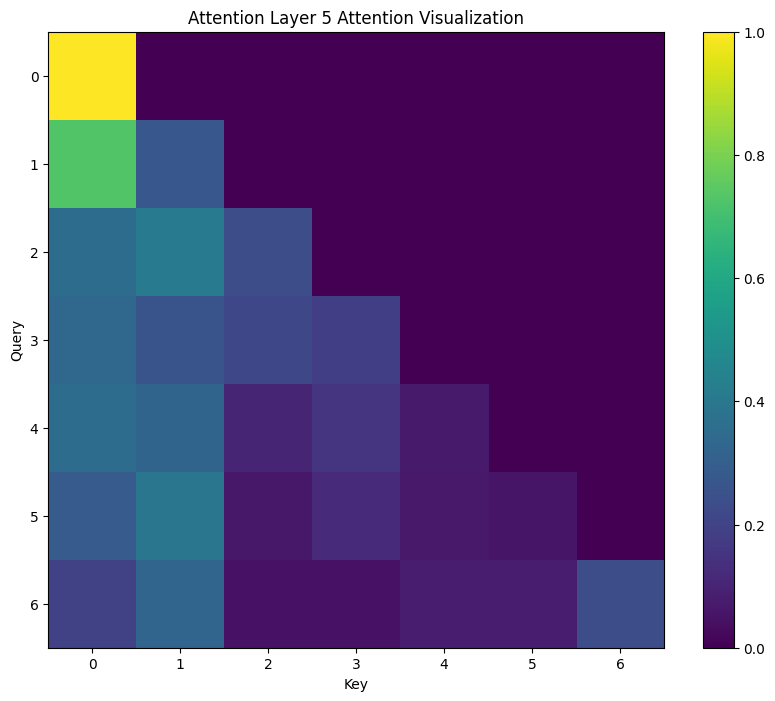

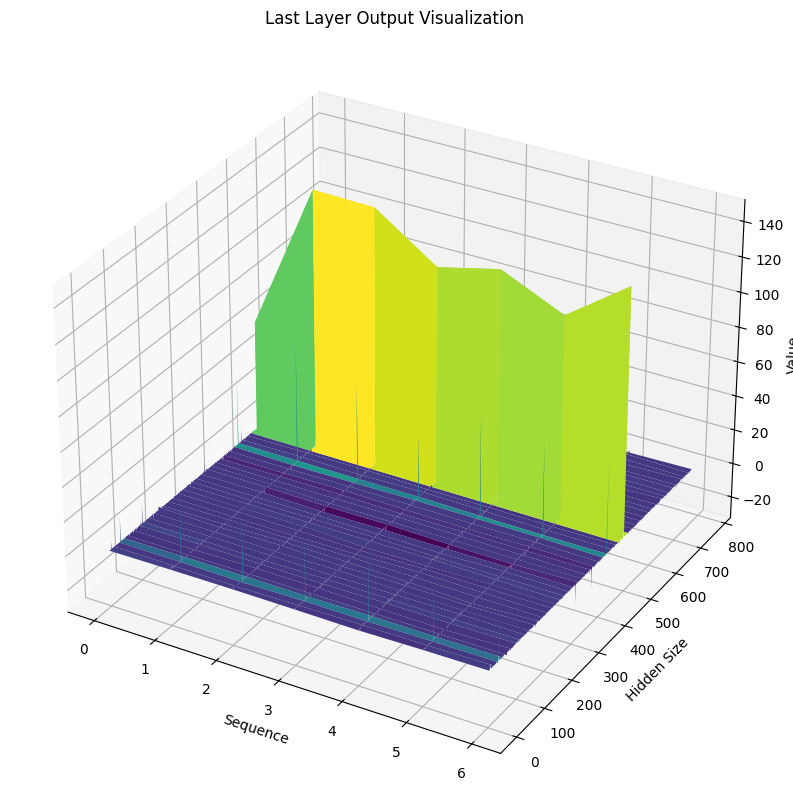

Last hidden state shape: torch.Size([1, 7, 768])
Number of layers: 7
Attention heads: 12


In [11]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModel.from_pretrained("distilgpt2")

# Move model to GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Function to visualize embeddings
def visualize_embeddings(embeddings, tokens):
    plt.figure(figsize=(20, 10))
    for i, token in enumerate(tokens):
        plt.stem(embeddings[i], linefmt=f'C{i}-', markerfmt=f'C{i}o', label=token)
    plt.legend()
    plt.title("Embedding Layer Visualization")
    plt.xlabel("Dimension")
    plt.ylabel("Value")
    plt.show()

# Updated function to visualize transformer layers in 3D
def visualize_transformer_3d(layer_output, layer_name):
    layer_output = layer_output[0].detach().cpu().numpy()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(layer_output.shape[0])
    y = np.arange(layer_output.shape[1])
    x, y = np.meshgrid(x, y)
    ax.plot_surface(x, y, layer_output.T, cmap='viridis')
    ax.set_title(f"{layer_name} Visualization")
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Hidden Size")
    ax.set_zlabel("Value")
    plt.show()

# Function to visualize attention
def visualize_attention(attention, layer_name):
    plt.figure(figsize=(10, 8))
    plt.imshow(attention[0, 0].detach().cpu().numpy(), cmap='viridis')
    plt.title(f"{layer_name} Attention Visualization")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.colorbar()
    plt.show()


def run_and_visualize(text):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

    # Visualize embeddings
    embeddings = model.wte(inputs['input_ids'][0]).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    visualize_embeddings(embeddings, tokens)

    # Visualize transformer layers and attention
    for i, (hidden_state, attention) in enumerate(zip(outputs.hidden_states, outputs.attentions)):
        visualize_transformer_3d(hidden_state, f"Transformer Layer {i}")
        visualize_attention(attention, f"Attention Layer {i}")

    # Visualize the output of the last layer
    last_layer_output = outputs.last_hidden_state
    visualize_transformer_3d(last_layer_output, "Last Layer Output")

    # Output metrics
    print(f"Last hidden state shape: {outputs.last_hidden_state.shape}")
    print(f"Number of layers: {len(outputs.hidden_states)}")
    print(f"Attention heads: {outputs.attentions[0].shape[1]}")

# Run the visualization
text = "Hello, how are you today?"
run_and_visualize(text)

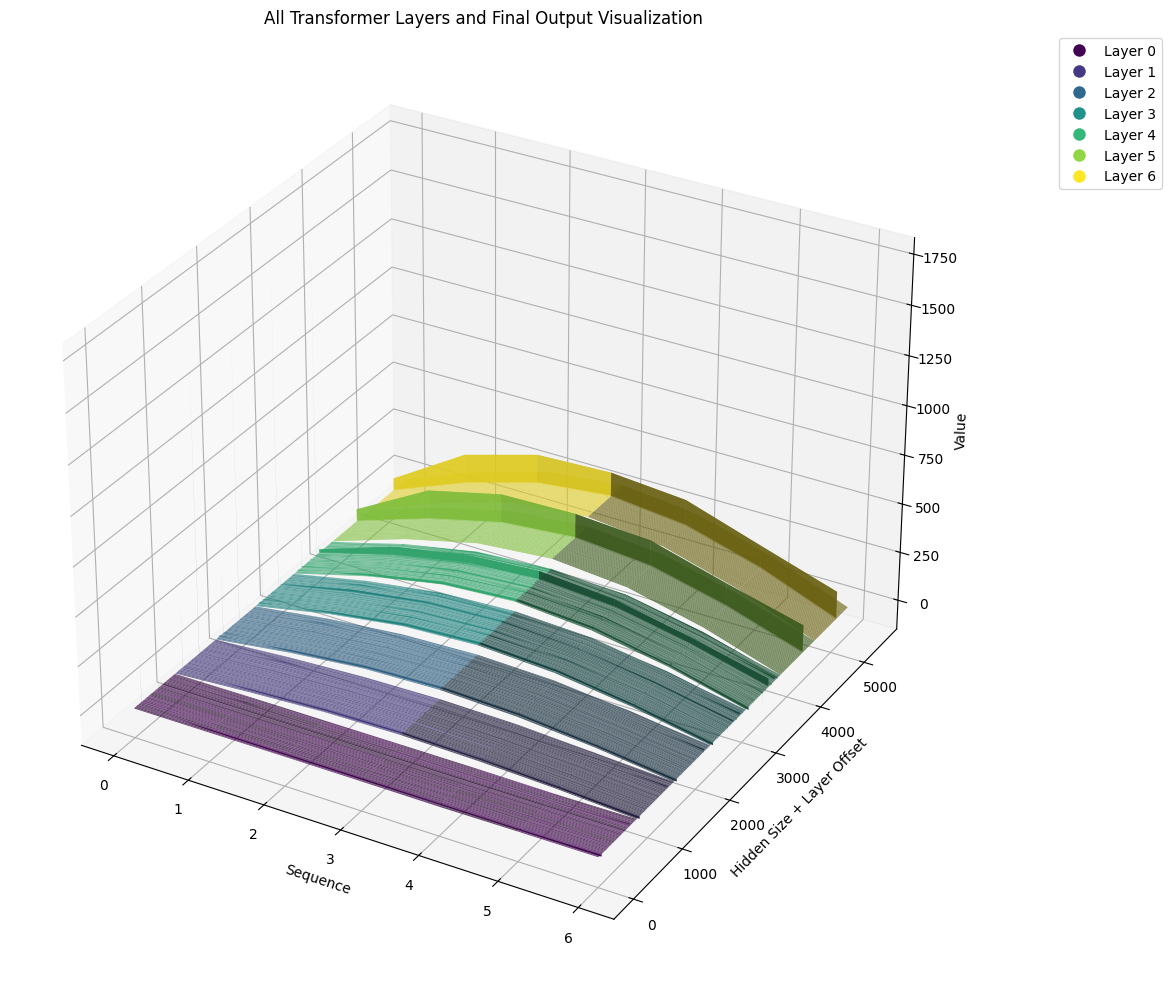

Last hidden state shape: torch.Size([1, 7, 768])
Number of layers: 7
Attention heads: 12


In [15]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModel.from_pretrained("distilgpt2")

# Move model to GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)


# Updated function to visualize all transformer layers and final output in 3D
def visualize_all_layers_3d(hidden_states):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')

    num_layers = len(hidden_states)
    seq_length = hidden_states[0].shape[1]
    hidden_size = hidden_states[0].shape[2]

    x = np.arange(seq_length)
    y = np.arange(hidden_size)
    x, y = np.meshgrid(x, y)

    colors = plt.cm.viridis(np.linspace(0, 1, num_layers))

    for i, layer_output in enumerate(hidden_states):
        z = layer_output[0].detach().cpu().numpy().T
        
        # Create a wave-like structure by offsetting layers
        offset = i * np.sin(np.linspace(0, np.pi, seq_length)) * 50
        
        ax.plot_surface(x, y + i * hidden_size, z + offset, 
                        color=colors[i], alpha=0.7, 
                        label=f'Layer {i}')

    ax.set_title("All Transformer Layers and Final Output Visualization")
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Hidden Size + Layer Offset")
    ax.set_zlabel("Value")
    
    # Add a custom legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                  label=f'Layer {i}', 
                                  markerfacecolor=color, markersize=10)
                       for i, color in enumerate(colors)]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.1, 1))

    plt.tight_layout()
    plt.show()

def run_and_visualize(text):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

    # Visualize embeddings
    embeddings = model.wte(inputs['input_ids'][0]).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Visualize all transformer layers and final output
    all_hidden_states = list(outputs.hidden_states[1:]) + [outputs.last_hidden_state]
    visualize_all_layers_3d(all_hidden_states)

    # Output metrics
    print(f"Last hidden state shape: {outputs.last_hidden_state.shape}")
    print(f"Number of layers: {len(outputs.hidden_states)}")
    print(f"Attention heads: {outputs.attentions[0].shape[1]}")

# Run the visualization
text = "Hello, how are you today?"
run_and_visualize(text)